# Лабораторная работа №1 по предмету "математика для машинного обучения"

- **Тема работы:** Регрессионный анализ
- **Выполнил:** Гришин А.Ю.
- **Группа:** М8О-106СВ-25
- **Вариант:** 4

In [1]:
import csv
import numpy as np

import matplotlib.pyplot as plt

import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics

In [2]:
RANDOM_SEED = 42

## 1. Загрузка датасета

Загрузим датасет, соответствующий выбранному варианту лабораторной работы. Так как в условии задания не было явно указано способа импорта датасета, то для этой задачи я выбрал стандартную библиотеку `csv`.

In [3]:
dataset = []

with open("datasets/lab1-04.csv", newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    for row in reader:
        dataset.append(tuple(map(float, row)))

dataset = np.array(dataset, dtype=np.float64)

## 2. Визуализация датасета

Визуализируем загруженный датасет в виде диаграммы рассеяния. Для визуализации воспользуемся библиотекой `matplotlib`.

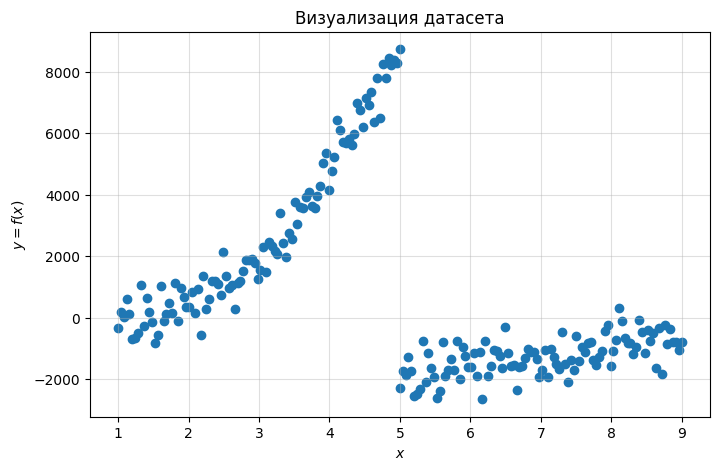

In [4]:
X, y = dataset[:, 0], dataset[:, 1]

plt.figure(figsize=(8, 5))
plt.scatter(X, y)
plt.title("Визуализация датасета")
plt.xlabel("$x$")
plt.ylabel("$y = f(x)$")
plt.grid(True, alpha=0.4)
plt.show()

Как видим, целевая функция $f(x)$ имеет форму кусочно-гладкой функции. При этом, точкой разрыва является $x = 5$.

## 3. Обучение модели регрессии

### Бейзлайн

Начнем с самого базового решения: простой линейной регрессии вида

$$
f(x) = c_1 \cdot x
$$

Данная регрессия имеет вид линейной функции всего с одним весом $c_1$.

In [6]:
X, y = dataset[:, 0], dataset[:, 1]
X = X.reshape((X.shape[0], 1))

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
  X, y,
  test_size=0.2,
  random_state=RANDOM_SEED,
)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)
print('R2 score:', sklearn.metrics.r2_score(y_test, model.predict(X_test)))

R2 score: 0.12235502001780518


Как видим, метрика $R ^ 2$ имеет очень низкие значения, что говорит нам о том, что модель плохо справляется с поставленной задачей. Значения, которые предсказывает модель на основе данных, слишком далеки от действительных в тестовой выборке.

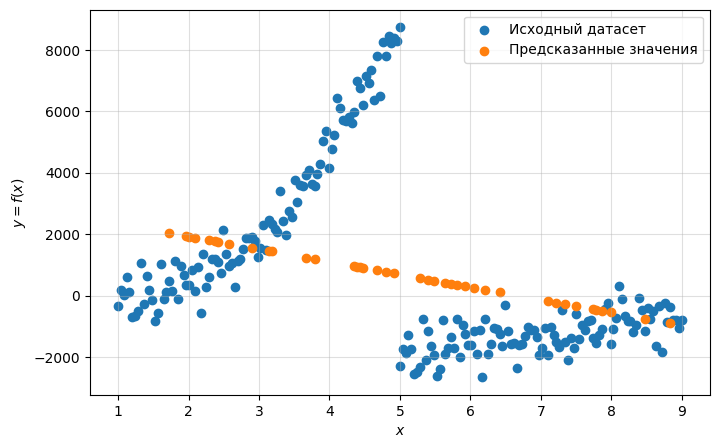

In [10]:
X, y = dataset[:, 0], dataset[:, 1]

plt.figure(figsize=(8, 5))
plt.scatter(X, y, label="Исходный датасет")
plt.scatter(X_test[:, 0], model.predict(X_test), label="Предсказанные значения")
plt.xlabel("$x$")
plt.ylabel("$y = f(x)$")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

То же самое можно и подтвердить визуально. Мы видим, что модель, в силу ограниченности входных значений, не может предсказывать более точные значения. Модель пытается найти тот угловой коэффициент, при котором погрешность будет наименьшей.

### Улучшение бейзлайна: Добавление степеней

На прошлом шаге была выдвинута гипотеза, что столь низкие показатели метрики $R ^ 2$ были обусловлены недостаточным количеством входной информации. Попробуем расширить входные признаки, воспользовавшись feature engineering.

При таком подходе мы пытаемся обогатить входные признаки через какие-нибудь функции (в основном, они нелинейные. В противном случае толку от дополнительных признаков мало).

Попробуем добавить кроме исходного входного признака значения переменной $x$ также значения ее квадрата $x ^ 2$ и константу $1$ для воозможности смещения значений.

In [11]:
X, y = dataset[:, 0], dataset[:, 1]
X = np.array([
    [x, x ** 2, 1]
    for x in X
], dtype=np.float64)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
  X, y,
  test_size=0.2,
  random_state=RANDOM_SEED,
)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)
print('R2 score:', sklearn.metrics.r2_score(y_test, model.predict(X_test)))

R2 score: 0.25375726131861287


Как видим, гипотеза подтвердилась! Показатель метрики $R ^ 2$ стал значительно выше в сравнении с прошлыми результатами. Однако, показатель метрики все еще далек от идеала (модели, которые хорошо решают задачу регрессии, обычно имеют показатели данной метрики $\ge 90\%$)

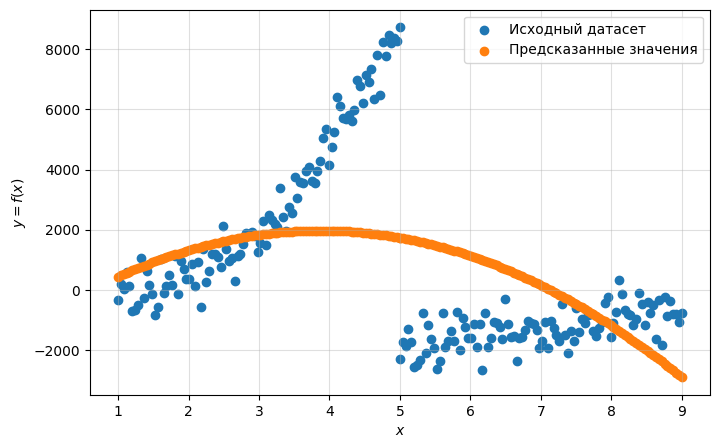

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], y, label="Исходный датасет")
plt.scatter(X[:, 0], model.predict(X), label="Предсказанные значения")
plt.xlabel("$x$")
plt.ylabel("$y = f(x)$")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

Как видим, полученная модель имеет вид гиперболы с направленными ветвями вниз. Интересно, что модель не решила полностью воспроизводить одну из частей кусочно-гладкой функции, а остановилась на "средне-оптимальном" представлении.

## Улучшение бейзлайна: добавление коэффициента

Ранее было отмечено, что целевая функция имеет форму кусочно-гладкой функции. Однако, до этого мы использовали для решения задачи регрессии только непрерывные функции.

Попробуем снова воспользоваться feature engineering и обогатить в этот раз входные признаки информацией о том, что целевая функция кусочно-гладкая.

Для этого введем переменную-коэффициент:

$$
a = \left\{
  \begin{matrix}
    1, & x \ge 5 \\
    0, & x < 5 \\
  \end{matrix}
\right.
$$

И попробуем представить модель следующим образом:

$$
f(x) =
a \cdot \left[ c_1 + c_2 \cdot x + c_3 \cdot x ^ 2 \right] +
(1 - a) \cdot \left[ c_4 + c_5 \cdot x + c_6 \cdot x ^ 2 \right]
$$

Иными словами, мы представляем модель в виде двух компонент, играющих
роль квадратичных функциий, но помноженных на введенный коэффициент.
Именно он и хранит информацию о кусочной гладкости функции: если входное значение $x \le 5$, то учитывается только первая компонента, иначе - только вторая.

In [14]:
def get_features(x):
  a = int(x >= 5.0)
  return [a, a * x, a * x ** 2, (1 - a), (1 - a) * x, (1 - a) * x ** 2]


X, y = dataset[:, 0], dataset[:, 1]
X = np.array([get_features(x) for x in X], dtype=np.float64)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
  X, y,
  test_size=0.2,
  random_state=RANDOM_SEED,
)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)
print('R2 score:', sklearn.metrics.r2_score(y_test, model.predict(X_test)))

R2 score: 0.9836822750509996


Как видим, модель показала прекрасные результаты, что говорит нам о том, что
гипотеза подтвердилась! Об этом свидетельствует значение метрики $R ^ 2$,
возросшее до $98\%$.

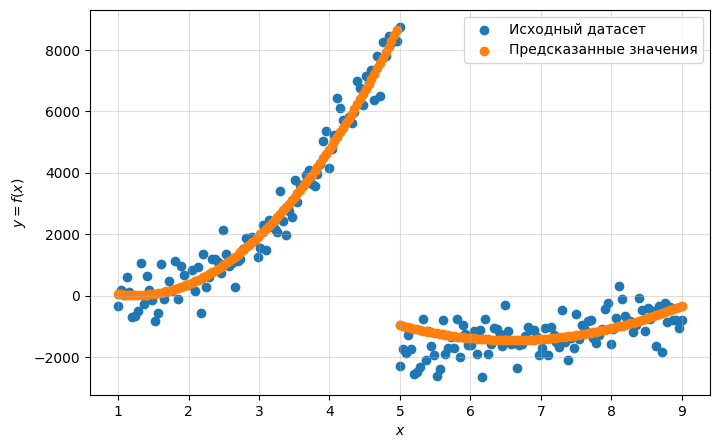

In [16]:
plt.figure(figsize=(8, 5))
plt.scatter(dataset[:, 0], y, label="Исходный датасет")
plt.scatter(dataset[:, 0], model.predict(X), label="Предсказанные значения")
plt.xlabel("$x$")
plt.ylabel("$y = f(x)$")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

Как видим, визуально также модель теперь учитывает кусочно-гладкий характер целевой функции.

## Итоги

| Модель | Значение $R ^ 2$ |
|----------|---|
| Бейзлайн | $0.12$ |
| Квадратичная функция | $0.25$ |
| 2 квадратичные функции с коэффициентом | $0.98$ |
